# An Exploration of Liquid Neural Networks:  A Dynamical Systems Approach to the Neural Network
Carter Smith, Henry Phillips, & Alexander Nichols
Artificial Neural Networks, Prof. Luchien Leahu, DIS Copengagen, 2024

## Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

## Implementing the RandomWiring Class
The RandomWiring class is responsible for defining the connection architecture between neurons. It initializes random adjacency matrices for neuron connections and sensory inputs. Those are used as an arbitrary sparsity matrix later in LIFNeuralLayer

In [2]:
class RandomWiring:
    def __init__(self, input_dim, output_dim, neuron_count):
        self.input_dim = input_dim  # Number of input features
        self.output_dim = output_dim  # Number of output features
        self.neuron_count = neuron_count  # Number of neurons in the layer
        self.adjacency_matrix = np.random.uniform(0, 1, (neuron_count, neuron_count))  # Adjacency matrix for connections between neurons
        self.sensory_adjacency_matrix = np.random.uniform(0, 1, (input_dim, neuron_count))  # Adjacency matrix for sensory inputs to neurons

    def erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.neuron_count, self.neuron_count))  # Initialize reversal potentials for neuron connections

    def sensory_erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.input_dim, self.neuron_count))  # Initialize reversal potentials for sensory inputs

## Implementing the LIFNeuronLayer Class
The LIFNeuronLayer class models the behavior of a layer of Leaky Integrate-and-Fire neurons, as mentioned above. 

In [3]:
class LIFNeuronLayer(nn.Module):
    def __init__(self, wiring, ode_unfolds=12, epsilon=1e-8):
        super(LIFNeuronLayer, self).__init__()
        self.wiring = wiring  # Wiring object containing connection information
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero
        self.softplus = nn.Softplus()  # Softplus activation function

        # Initialization ranges for parameters
        GLEAK_MIN, GLEAK_MAX = 0.001, 1.0
        VLEAK_MIN, VLEAK_MAX = -0.2, 0.2
        CM_MIN, CM_MAX = 0.4, 0.6
        W_MIN, W_MAX = 0.001, 1.0
        SIGMA_MIN, SIGMA_MAX = 3, 8
        MU_MIN, MU_MAX = 0.3, 0.8
        SENSORY_W_MIN, SENSORY_W_MAX = 0.001, 1.0
        SENSORY_SIGMA_MIN, SENSORY_SIGMA_MAX = 3, 8
        SENSORY_MU_MIN, SENSORY_MU_MAX = 0.3, 0.8

        # Initialize neuron parameters with random values within specified ranges
        self.gleak = nn.Parameter(torch.rand(wiring.neuron_count) * (GLEAK_MAX - GLEAK_MIN) + GLEAK_MIN)
        self.vleak = nn.Parameter(torch.rand(wiring.neuron_count) * (VLEAK_MAX - VLEAK_MIN) + VLEAK_MIN)
        self.cm = nn.Parameter(torch.rand(wiring.neuron_count) * (CM_MAX - CM_MIN) + CM_MIN)
        self.w = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (W_MAX - W_MIN) + W_MIN)
        self.sigma = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (SIGMA_MAX - SIGMA_MIN) + SIGMA_MIN)
        self.mu = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (MU_MAX - MU_MIN) + MU_MIN)
        self.erev = nn.Parameter(torch.Tensor(wiring.erev_initializer()))
        
        # Initialize sensory parameters with random values within specified ranges
        self.sensory_w = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_W_MAX - SENSORY_W_MIN) + SENSORY_W_MIN)
        self.sensory_sigma = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_SIGMA_MAX - SENSORY_SIGMA_MIN) + SENSORY_SIGMA_MIN)
        self.sensory_mu = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_MU_MAX - SENSORY_MU_MIN) + SENSORY_MU_MIN)
        self.sensory_erev = nn.Parameter(torch.Tensor(wiring.sensory_erev_initializer()))

        # Sparsity masks (fixed, non-learnable) based on the wiring adjacency matrices
        self.sparsity_mask = torch.Tensor(np.abs(wiring.adjacency_matrix))
        self.sensory_sparsity_mask = torch.Tensor(np.abs(wiring.sensory_adjacency_matrix))

    def forward(self, inputs, state, elapsed_time=1.0):
        return self.ode_solver(inputs, state, elapsed_time)

    def ode_solver(self, inputs, state, elapsed_time):
        v_pre = state  # Previous state (voltage)

        # Pre-compute the effects of the sensory neurons
        sensory_activation = self.softplus(self.sensory_w) * self.sigmoid(inputs, self.sensory_mu, self.sensory_sigma)
        sensory_activation = sensory_activation * self.sensory_sparsity_mask
        sensory_reversal_activation = sensory_activation * self.sensory_erev

        # Calculate the numerator and denominator for sensory inputs
        w_numerator_sensory = torch.sum(sensory_reversal_activation, dim=1)
        w_denominator_sensory = torch.sum(sensory_activation, dim=1)

        # Calculate membrane capacitance over time
        cm_t = self.softplus(self.cm) / (elapsed_time / self.ode_unfolds)

        # Initialize weights for neuron connections
        w_param = self.softplus(self.w)
        for _ in range(self.ode_unfolds):
            # Activation based on previous state
            w_activation = w_param * self.sigmoid(v_pre, self.mu, self.sigma)
            w_activation = w_activation * self.sparsity_mask
            reversal_activation = w_activation * self.erev

            # Calculate the numerator and denominator for neuron connections
            w_numerator = torch.sum(reversal_activation, dim=1) + w_numerator_sensory
            w_denominator = torch.sum(w_activation, dim=1) + w_denominator_sensory

            # Leak conductance and voltage calculations
            gleak = self.softplus(self.gleak)
            numerator = cm_t * v_pre + gleak * self.vleak + w_numerator
            denominator = cm_t + gleak + w_denominator

            # Update the state (voltage)
            v_pre = numerator / (denominator + self.epsilon)

        return v_pre

    def sigmoid(self, v_pre, mu, sigma):
        v_pre = torch.unsqueeze(v_pre, -1)  # Unsqueeze to match dimensions
        activation = sigma * (v_pre - mu)  # Apply sigma and mean shift
        return torch.sigmoid(activation)  # Apply sigmoid activation

## Implementing the LNNCell Class
The LNNCell class represents a single cell in our LNN Recurrent Neural Network. It uses the LIFNeuronLayer to update neuron states.

Note: we did assume that the amount of neurons is always greater than the output dimmension, so we just trim them into outputs. 

In [4]:
class LNNCell(nn.Module):
    def __init__(self, wiring, in_features=None, ode_unfolds=6, epsilon=1e-8):
        super(LNNCell, self).__init__()        
        self.wiring = wiring  # Wiring object
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero

        self.neuron = LIFNeuronLayer(wiring, ode_unfolds, epsilon)  # Initialize LIFNeuron with the given wiring

    def forward(self, inputs, states, elapsed_time=1.0):
        next_state = self.neuron(inputs, states, elapsed_time)  # Compute the next state using the neuron model
        outputs = next_state[:, :self.wiring.output_dim] # Map the state to the output dimensions
        return outputs, next_state

## Implementing the LNNRNN Class
The LTCRNN class constructs the recurrent neural network using multiple LNNCell instances. It processes sequences of inputs to produce sequences of outputs.

In [5]:
class LNNRNN(nn.Module):
    def __init__(self, wiring, input_dim, hidden_dim, output_dim):
        super(LNNRNN, self).__init__()
        self.cell = LNNCell(wiring, in_features=input_dim)  # Initialize LTCCell with wiring and input dimension
        self.hidden_dim = hidden_dim  # Number of hidden neurons
        self.output_dim = output_dim  # Number of output neurons
        
    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.size()  # Get batch size and sequence length from input dimensions
        
        states = torch.zeros(batch_size, self.hidden_dim)  # Initialize hidden states with zeros
            
        outputs = []  # List to store outputs for each time step

        for t in range(seq_len):
            output, states = self.cell(inputs[:, t, :], states)  # Compute output and next state for each time step
            outputs.append(output)  # Append the output to the list

        result = torch.stack(outputs, dim=1)  # Stack the outputs along the sequence dimension
        return result

This marks our first interest with this model:

#### 1) Approaching these problems with a dynamical systems lens could provide robust ability to handle highly complex, continuous datasets.

Plus, with this much math, there's no way the model doesn't work!!! (right?)

## Let's get Training!
Next, we set the hyperparameters and prepare some data for training. We'll tackle two continuous, complex problems:
1) Tracking a traditional 2D spiral
2) Categorizing human movement based on gyroscopic data

In [6]:
# Generate spiral data
def generate_spiral_data(num_points, num_turns, noise = 2):
    theta = np.linspace(0, num_turns * 2 * np.pi, num_points)
    z = np.linspace(0, 1, num_points)
    r = z
    x = r * np.sin(theta) + noise * np.random.randn(*theta.shape) / num_points
    y = r * np.cos(theta) + noise * np.random.randn(*theta.shape) / num_points
    return np.stack([x, y], axis=1)

Epoch [200/400], Total train loss: 0.0067, Total val loss: 0.0003


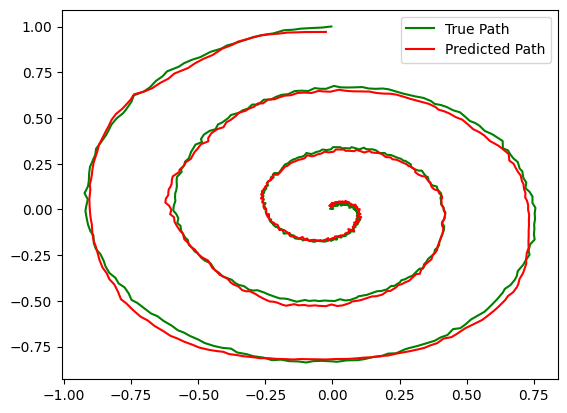

Epoch [400/400], Total train loss: 0.0015, Total val loss: 0.0001


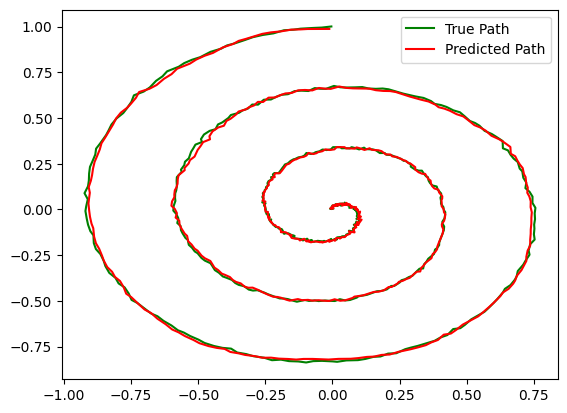

In [7]:
# Hyperparameters
input_dim = 2 # Number of input dimensions
hidden_dim = 8 # Number of hidden dimensions (number of neurons in LIFNeuralLayer)
output_dim = 2 # Number of output dimensions
num_points = 500 # Number of spiral points in dataset
num_turns = 3 # Number of spiral turns
learning_rate = 0.005
num_epochs = 400
seq_len = 3 # Maximum length of the sample sequence
batch_size = 32

# Generate data
data = generate_spiral_data(num_points, num_turns)
all_inputs = data[:-1, :]
all_targets = data[1:, :]

# Prepare input and target sequences
trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

# Shuffle and split the data for training
random_train_indices = np.arange(len(train_inputs))
np.random.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

# Function to create batches
def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

# Create input and target batches
train_input_batches = create_batches(train_inputs, batch_size)
train_target_batches = create_batches(train_targets, batch_size)

# Initialize model
wiring = RandomWiring(input_dim, output_dim, hidden_dim)
modelfirst = LNNRNN(wiring, input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelfirst.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    modelfirst.train()    
    total_loss = 0

    # Iterate over batches
    for x, y_target in zip(train_input_batches, train_target_batches):
        optimizer.zero_grad()
        x = torch.stack(x)  # Stack batch of sequences
        y_target = torch.stack(y_target)  # Stack batch of targets
        outputs = modelfirst(x)  # Forward pass through the model
        loss = criterion(outputs, y_target)  # Compute loss

        # Accumulate total loss and perform backward pass and optimization step
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Print loss every 100 epochs and plot predictions
    if (epoch + 1) % 200 == 0:
        # Prediction and plotting
        modelfirst.eval()
        with torch.no_grad():
            predictions = modelfirst(torch.FloatTensor(all_inputs).unsqueeze(0))
            np_predictions = predictions.squeeze(0).numpy()
            val_loss = criterion(predictions, torch.FloatTensor(all_targets).unsqueeze(0))  # Compute loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Total train loss: {total_loss:.4f}, Total val loss: {val_loss:.4f}')

        plt.plot(all_targets[:, 0], all_targets[:, 1], 'g-', label='True Path')
        plt.plot(np_predictions[:, 0], np_predictions[:, 1], 'r-', label='Predicted Path')
        plt.legend()
        plt.show()

# Optimized RNN Attempt


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch [200/400], Loss: 0.0044, MAE: 0.0452
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


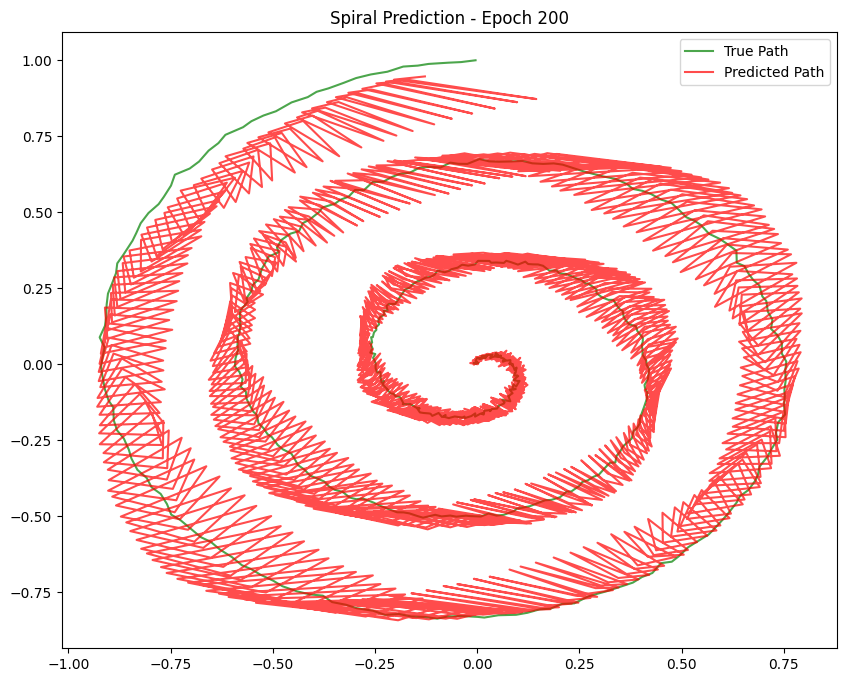

Epoch [400/400], Loss: 0.0018, MAE: 0.0307
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


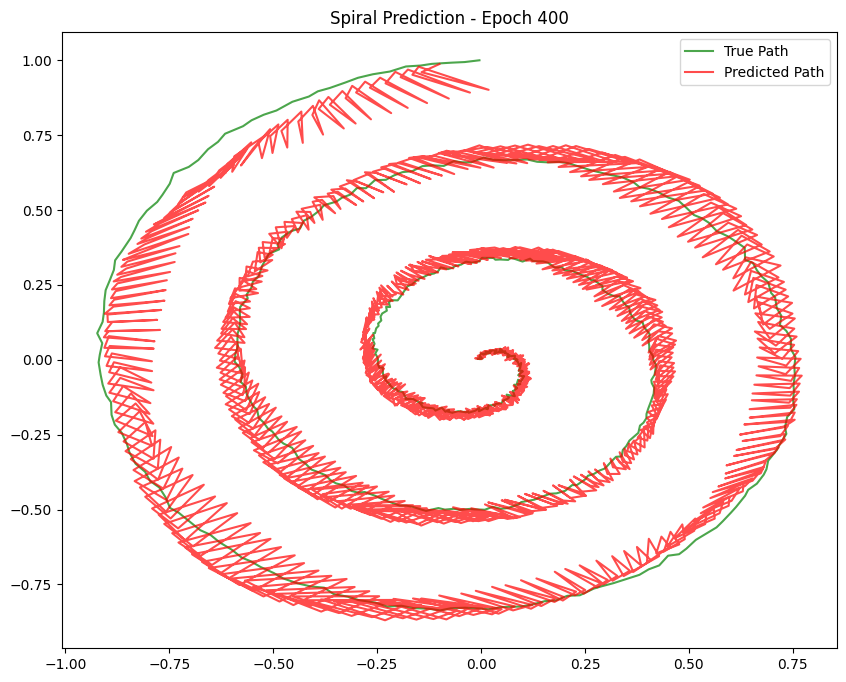

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import SGD


# Prepare input and target sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X = create_sequences(all_inputs, seq_len)
y = create_sequences(all_targets, seq_len)

# Reshape X to (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], input_dim))

# Define TensorFlow SimpleRNN model
simple_rnn_model = Sequential([
    SimpleRNN(6, activation='tanh', return_sequences=True, input_shape=(seq_len, input_dim)),
    Dense(output_dim, activation='linear')
])

simple_rnn_model.compile(
    loss='mse',
    optimizer=SGD(learning_rate=learning_rate),
    metrics=['mae']
)

# Training loop

for epoch in range(num_epochs):
    history = simple_rnn_model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0)
    
    # Print loss every 100 epochs and plot predictions
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {history.history["loss"][0]:.4f}, MAE: {history.history["mae"][0]:.4f}')
        
        # Generate predictions
        predictions = simple_rnn_model.predict(X)
        predictions = predictions.reshape(-1, output_dim)
        
        # Plot the results
        plt.figure(figsize=(10, 8))
        plt.plot(all_targets[:, 0], all_targets[:, 1], 'g-', label='True Path', alpha=0.7)
        plt.plot(predictions[:, 0], predictions[:, 1], 'r-', label='Predicted Path', alpha=0.7)
        plt.title(f'Spiral Prediction - Epoch {epoch+1}')
        plt.legend()
        plt.show()


Woah. This looks crazy. Techically the RNN wins based on loss, but what does your eye tell you? Our hypothesis is that: the RNN is so hyper-researched and optimized to limit loss, but which model would you take here?

If we use an even more effective optimizer, we see the RNN does brilliantly.

Epoch [400/400], Loss: 0.0001, MAE: 0.0060
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


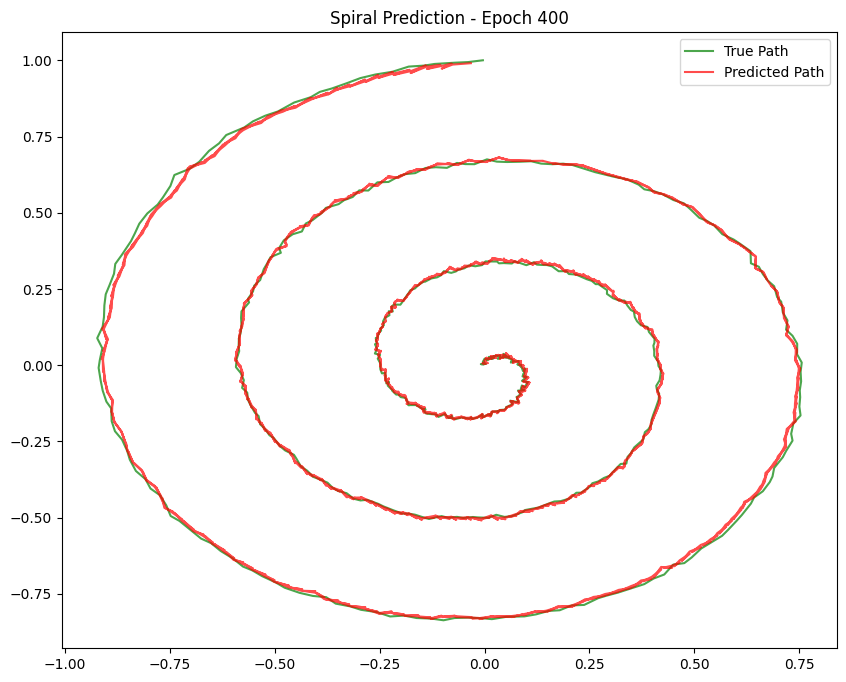

In [9]:
from tensorflow.keras.optimizers import Adam


# Prepare input and target sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X = create_sequences(all_inputs, seq_len)
y = create_sequences(all_targets, seq_len)

# Reshape X to (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], input_dim))

# Define TensorFlow SimpleRNN model
simple_rnn_model = Sequential([
    SimpleRNN(6, activation='tanh', return_sequences=True, input_shape=(seq_len, input_dim)),
    Dense(output_dim, activation='linear')
])

simple_rnn_model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=learning_rate), #SEE HERE, THE MUCH BETTER OPTIMIZER
    metrics=['mae']
)

# Training loop
for epoch in range(num_epochs):
    history = simple_rnn_model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0)
    
    # Print loss every 100 epochs and plot predictions
    if (epoch + 1) % 400 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {history.history["loss"][0]:.4f}, MAE: {history.history["mae"][0]:.4f}')
        
        # Generate predictions
        predictions = simple_rnn_model.predict(X)
        predictions = predictions.reshape(-1, output_dim)
        
        # Plot the results
        plt.figure(figsize=(10, 8))
        plt.plot(all_targets[:, 0], all_targets[:, 1], 'g-', label='True Path', alpha=0.7)
        plt.plot(predictions[:, 0], predictions[:, 1], 'r-', label='Predicted Path', alpha=0.7)
        plt.title(f'Spiral Prediction - Epoch {epoch+1}')
        plt.legend()
        plt.show()

Absolutely beautiful. But this got us thinking. 

The model it's up against was assembled by three students, young minds in this field. While it does not post the loss performance as the two RNN trails do, imagine how the LNN performs with the same amount of research and tuning the RNN had. 

This marks our second reason for being excited about this architecture: 

#### 2) It's so young! This new, relatively untested neural network philosophy has high potential. 

## How do the LNN and RNN handle more complex data?

This HAR dataset should be a larger challenge for these models. Each will have 6 hidden layers and we will continue to use the SGD optimizer for the RNN. 

### Here, we see the LNN does surprisingly well with such a small model. 

In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np



# Load X_train and y_train
X_train = np.loadtxt('data/train/X_train.txt')  # Replace with the correct path
y_train = np.loadtxt('data/train/y_train.txt')       # Replace with the correct path

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) - 1  # Labels start from 1, adjust to 0-based indexing

X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape: [batch_size, seq_len=1, input_dim=561]



In [11]:
# TRAIN AND TEST!

# Update wiring configuration
input_dim = 561
hidden_dim = 6 # Small hidden layer size
output_dim = 6

wiring = RandomWiring(input_dim=input_dim, output_dim=output_dim, neuron_count=hidden_dim)
lnnHAR = LNNRNN(wiring=wiring, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Create DataLoader for batching
batch_size = 64
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lnnHAR.parameters(), lr=0.001)

from sklearn.metrics import accuracy_score

# Initialize lists to store accuracy
train_acc_list = []
val_acc_list = []  # If you have a validation set

epochs = 10
for epoch in range(epochs):
    lnnHAR.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lnnHAR(X_batch)  # Forward pass through LNN
        loss = criterion(outputs[:, -1], y_batch)  # Use last time step's output
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights
        
        total_loss += loss.item()

        # Calculate training accuracy for this batch
        predictions = torch.argmax(outputs[:, -1], dim=1)
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    # Compute epoch accuracy
    train_accuracy = correct / total
    train_acc_list.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}')



# Load test set (similar to training data preparation)
X_test = np.loadtxt('data/test/X_test.txt')  # Replace with correct path
y_test = np.loadtxt('data/test/y_test.txt') - 1

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Evaluate model
lnnHAR.eval()
with torch.no_grad():
    outputs = lnnHAR(X_test_tensor)
    predictions = torch.argmax(outputs[:, -1], dim=1).numpy()
    accuracy = accuracy_score(y_test_tensor.numpy(), predictions)

print(f'Test Accuracy for LNN on HAR: {accuracy:.4f}')

# If you have a validation set, repeat similar steps for validation accuracy

Epoch [1/10], Loss: 1.7585, Accuracy: 0.4279
Epoch [2/10], Loss: 1.6735, Accuracy: 0.6726
Epoch [3/10], Loss: 1.5524, Accuracy: 0.7205
Epoch [4/10], Loss: 1.4027, Accuracy: 0.7946
Epoch [5/10], Loss: 1.2413, Accuracy: 0.8289
Epoch [6/10], Loss: 1.0851, Accuracy: 0.8599
Epoch [7/10], Loss: 0.9432, Accuracy: 0.8830
Epoch [8/10], Loss: 0.8189, Accuracy: 0.8979
Epoch [9/10], Loss: 0.7117, Accuracy: 0.9048
Epoch [10/10], Loss: 0.6216, Accuracy: 0.9095
Test Accuracy for LNN on HAR: 0.8850


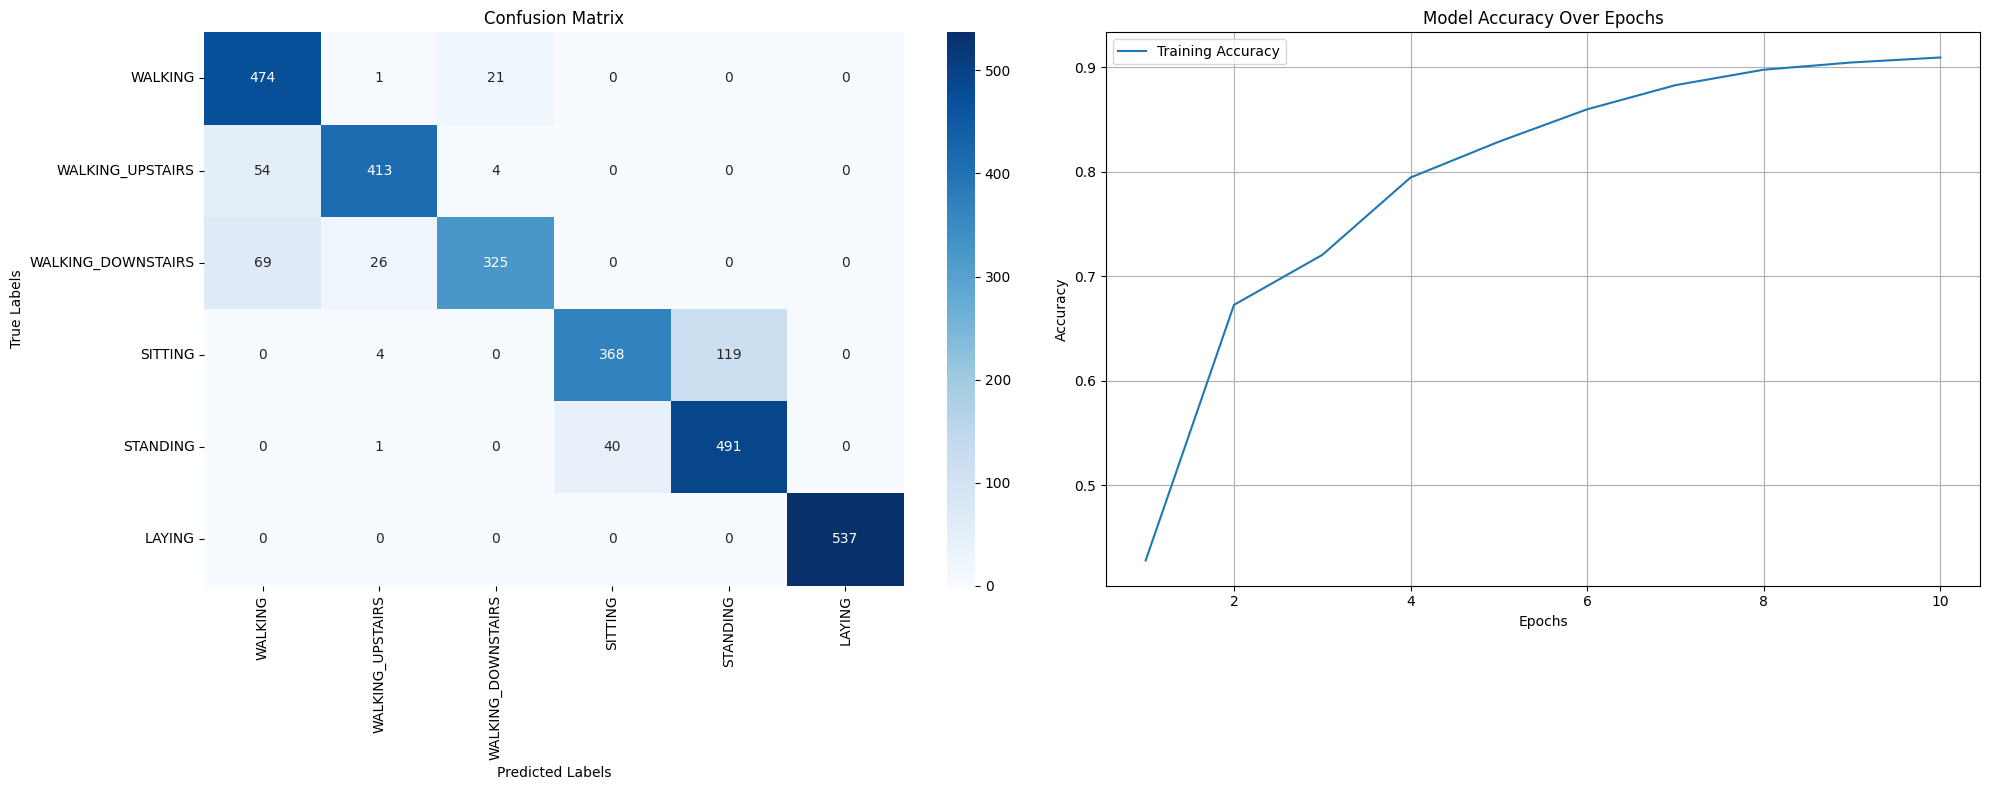

In [12]:
num_classes = 6  # Define the number of classes

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test_tensor.numpy(), predictions)  # Ensure correct arguments

# Visualize the confusion matrix


# Create a figure with two subplots side by side
fig, (ax1LNNHAR, ax2LNNHAR) = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
            ax=ax1LNNHAR)
ax1LNNHAR.set_xlabel('Predicted Labels')
ax1LNNHAR.set_ylabel('True Labels')
ax1LNNHAR.set_title('Confusion Matrix')

# Accuracy plot
epochs_range = range(1, epochs + 1)
ax2LNNHAR.plot(epochs_range, train_acc_list, label='Training Accuracy')
# Uncomment below if you have validation accuracy
# ax2.plot(epochs_range, val_acc_list, label='Validation Accuracy')
ax2LNNHAR.set_xlabel('Epochs')
ax2LNNHAR.set_ylabel('Accuracy')
ax2LNNHAR.set_title('Model Accuracy Over Epochs')
ax2LNNHAR.legend()
ax2LNNHAR.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# RNN

### Great work from the LNN. How does the same sized RNN perform?

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.1840 - loss: 1.8225
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.2791 - loss: 1.7787
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.2978 - loss: 1.7661
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.2998 - loss: 1.7556
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.3046 - loss: 1.7455
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.3192 - loss: 1.7360
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.3284 - loss: 1.7305
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.3340 - loss: 1.7184
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.3367 - loss: 1.7139
Epoch 10/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.3478 - loss: 1.7061
   RNN Loss: 1.7051, Accuracy: 0.3422
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
Test Accuracy (SimpleRNN): 0.3332


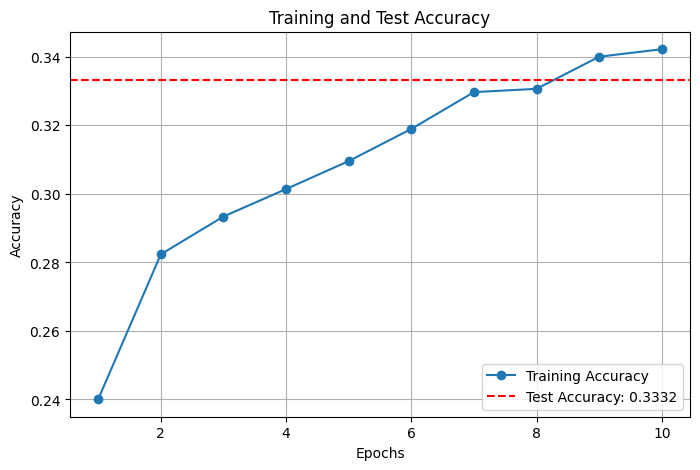

In [13]:
input_size = X_train_tensor.shape[2]  # Number of features per time step
hidden_size = 6                     # Hidden layer size
output_size = len(torch.unique(y_train_tensor))  # Number of classes


# Define TensorFlow SimpleRNN model
simple_rnn_model6 = Sequential([
    SimpleRNN(6, activation='relu', return_sequences=False, input_shape=(None, input_size)),
    Dense(output_size, activation='softmax')  # Output layer for classification
])

simple_rnn_model6.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)

X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
train_acc_list_rnn = []  # For TensorFlow SimpleRNN

#### Train TensorFlow SimpleRNN ####
history_rnn = simple_rnn_model6.fit(
    X_train_np,
    y_train_np,
    batch_size=64,
    epochs=10
)

train_accuracy_rnn = history_rnn.history['accuracy'][-1]
train_acc_list_rnn.append(train_accuracy_rnn)

print(f"   RNN Loss: {history_rnn.history['loss'][-1]:.4f}, Accuracy: {train_accuracy_rnn:.4f}")

# Load test set (replace with your actual file paths)
X_test = np.loadtxt('data/test/X_test.txt')  # Replace with correct path
y_test = np.loadtxt('data/test/y_test.txt') - 1  # Adjust labels if necessary (e.g., subtract 1)

# Ensure X_test has the correct shape for SimpleRNN
X_test = X_test.reshape((X_test.shape[0], -1, X_test.shape[1]))  # Reshape to (samples, timesteps, features)

# Make predictions using the trained SimpleRNN model
y_pred_probs = simple_rnn_model6.predict(X_test)  # Predict probabilities
y_pred_classes6 = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_classes6)

print(f'Test Accuracy (SimpleRNN): {accuracy:.4f}')

# Training accuracy from the history object
train_accuracy = history_rnn.history['accuracy']

# Test accuracy (single value)
test_accuracy = accuracy

# Create a plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()




Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.1681 - loss: 1.8293
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5395 - loss: 1.3398
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6548 - loss: 1.1536
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7193 - loss: 1.0438
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7549 - loss: 0.9531
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7984 - loss: 0.8787
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8126 - loss: 0.8254
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.8200 - loss: 0.7724
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.8459 - loss: 0.7332
Epoch 10/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.8448 - loss: 0.7032
   RNN Loss: 0.6946, Accuracy: 0.8500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step


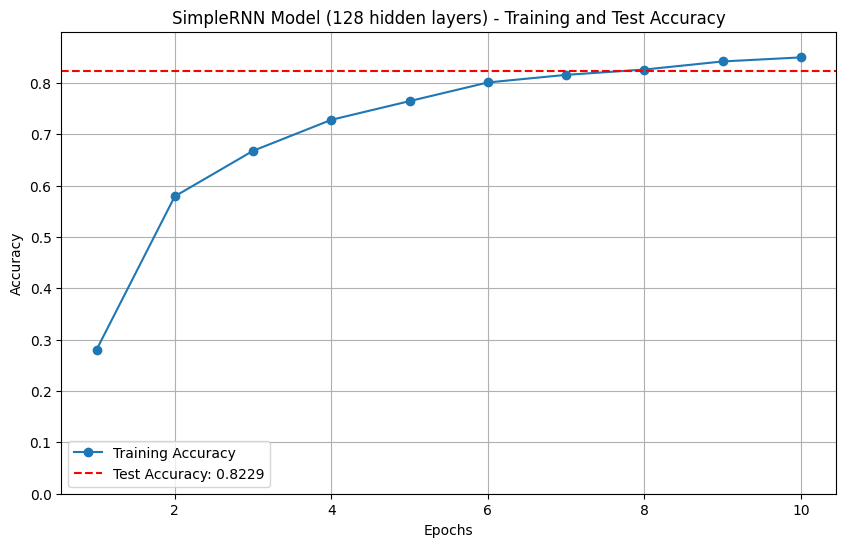

In [14]:

# Define TensorFlow SimpleRNN model
simple_rnn_model128 = Sequential([
    SimpleRNN(128, activation='relu', return_sequences=False, input_shape=(None, input_size)),
    Dense(output_size, activation='softmax')  # Output layer for classification
])

simple_rnn_model128.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)

X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
train_acc_list_rnn = []  # For TensorFlow SimpleRNN

#### Train TensorFlow SimpleRNN ####
history_rnn128 = simple_rnn_model128.fit(
    X_train_np,
    y_train_np,
    batch_size=64,
    epochs=10
)

train_accuracy_rnn = history_rnn128.history['accuracy'][-1]
train_acc_list_rnn.append(train_accuracy_rnn)

print(f"   RNN Loss: {history_rnn128.history['loss'][-1]:.4f}, Accuracy: {train_accuracy_rnn:.4f}")

# Load test set (replace with your actual file paths)
X_test = np.loadtxt('data/test/X_test.txt')  # Replace with correct path
y_test = np.loadtxt('data/test/y_test.txt') - 1  # Adjust labels if necessary (e.g., subtract 1)

# Ensure X_test has the correct shape for SimpleRNN
X_test = X_test.reshape((X_test.shape[0], -1, X_test.shape[1]))  # Reshape to (samples, timesteps, features)

# Make predictions using the trained SimpleRNN model
y_pred_probs = simple_rnn_model128.predict(X_test)  # Predict probabilities
y_pred_classes128 = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_classes128)


# Extract training accuracy from history
train_accuracy = history_rnn128.history['accuracy']

# Test accuracy (single value)
test_accuracy = accuracy

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')

plt.title('SimpleRNN Model (128 hidden layers) - Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust y-axis to start from 0 and end slightly above the maximum accuracy
plt.ylim(0, max(max(train_accuracy), test_accuracy) + 0.05)

plt.show()




It's worth noting – using the Adam optimizer will produce much stronger results for the RNN. Despite this, we are quite proud of our simple LNN's performance here. We've been convinced of this dynamical systems approach.

To summarize our initial excitement for this architecture:
1) Approaching these problems with a dynamical systems lens could provide robust ability to handle highly complex, continuous datasets.
2) It's so young! This new, relatively untested neural network philosophy has high potential. 

Our experiements have only increased our excitement. 
a) 3 students threw this LNN together
b) it lost, but performed well against the SGD RNN for the spiral data
c) imagine the LNN with the highly researched optimization of Adam
d) on complex, continuious data, LNN performed very well, beating out performance of an RNN more than 20x larger. 
e) next steps are researching the math more and taking a stab at an optimizer that can compete with Adam. 

# Playground!!

### If you'd like, here is an area to play with our LNN. Play with the hyperparameters to see how the model's performance changes. 

Epoch [1/10], Loss: 1.7669, Accuracy: 0.4553
Epoch [2/10], Loss: 1.6895, Accuracy: 0.6148
Epoch [3/10], Loss: 1.5791, Accuracy: 0.7129
Epoch [4/10], Loss: 1.4391, Accuracy: 0.8056
Epoch [5/10], Loss: 1.2834, Accuracy: 0.8361
Epoch [6/10], Loss: 1.1266, Accuracy: 0.8625
Epoch [7/10], Loss: 0.9809, Accuracy: 0.8785
Epoch [8/10], Loss: 0.8508, Accuracy: 0.8860
Epoch [9/10], Loss: 0.7409, Accuracy: 0.8943
Epoch [10/10], Loss: 0.6499, Accuracy: 0.9010
Test Accuracy for LNN on HAR: 0.8812


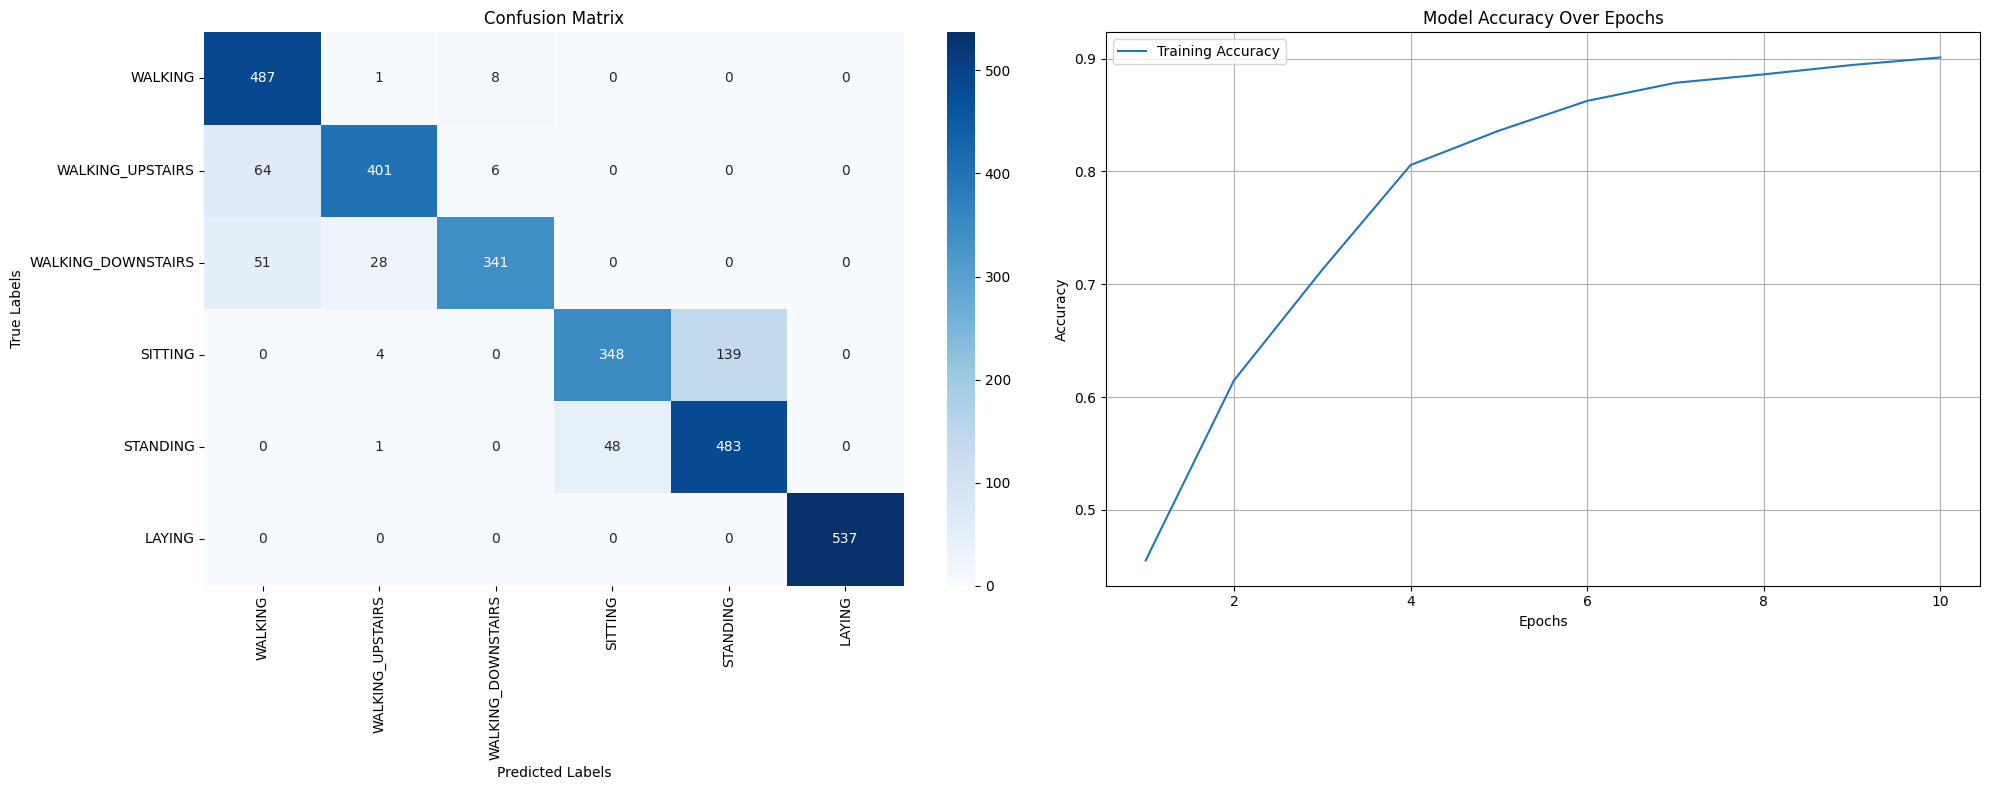

In [15]:
# Update wiring configuration
input_dim = 561
hidden_dim = 6 # Small hidden layer size
output_dim = 6






wiring = RandomWiring(input_dim=input_dim, output_dim=output_dim, neuron_count=hidden_dim)
lnnHAR = LNNRNN(wiring=wiring, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Create DataLoader for batching
batch_size = 64
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lnnHAR.parameters(), lr=0.001)

from sklearn.metrics import accuracy_score

# Initialize lists to store accuracy
train_acc_list = []
val_acc_list = []  # If you have a validation set

epochs = 10
for epoch in range(epochs):
    lnnHAR.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lnnHAR(X_batch)  # Forward pass through LNN
        loss = criterion(outputs[:, -1], y_batch)  # Use last time step's output
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights
        
        total_loss += loss.item()

        # Calculate training accuracy for this batch
        predictions = torch.argmax(outputs[:, -1], dim=1)
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    # Compute epoch accuracy
    train_accuracy = correct / total
    train_acc_list.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}')



# Load test set (similar to training data preparation)
X_test = np.loadtxt('data/test/X_test.txt')  # Replace with correct path
y_test = np.loadtxt('data/test/y_test.txt') - 1

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Evaluate model
lnnHAR.eval()
with torch.no_grad():
    outputs = lnnHAR(X_test_tensor)
    predictions = torch.argmax(outputs[:, -1], dim=1).numpy()
    accuracy = accuracy_score(y_test_tensor.numpy(), predictions)

print(f'Test Accuracy for LNN on HAR: {accuracy:.4f}')

# If you have a validation set, repeat similar steps for validation accuracy

num_classes = 6  # Define the number of classes

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test_tensor.numpy(), predictions)  # Ensure correct arguments

# Visualize the confusion matrix


# Create a figure with two subplots side by side
fig, (ax3LNNHAR, ax4LNNHAR) = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
            ax=ax3LNNHAR)
ax3LNNHAR.set_xlabel('Predicted Labels')
ax3LNNHAR.set_ylabel('True Labels')
ax3LNNHAR.set_title('Confusion Matrix')

# Accuracy plot
epochs_range = range(1, epochs + 1)
ax4LNNHAR.plot(epochs_range, train_acc_list, label='Training Accuracy')
# Uncomment below if you have validation accuracy
# ax2.plot(epochs_range, val_acc_list, label='Validation Accuracy')
ax4LNNHAR.set_xlabel('Epochs')
ax4LNNHAR.set_ylabel('Accuracy')
ax4LNNHAR.set_title('Model Accuracy Over Epochs')
ax4LNNHAR.legend()
ax4LNNHAR.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

###Acknowledgements 

This tutorial is based on the references 
1) [Liquid Neural Networks original publication](https://arxiv.org/abs/2006.04439)
2) [LTCCell implementation](https://github.com/mlech26l/ncps/blob/master/ncps/torch/ltc_cell.py)
2) [LTC Network application](https://github.com/KPEKEP/LTCtutorial/blob/main/LNN_LTC_Tutorial_Eng.ipynb)
